In [0]:
## URL : 
## https://www.dataiku.com/learn/guide/tutorials/churn-prediction.html

In [2]:
## download data
!wget https://downloads.dataiku.com/tutorials/v2.0/TUTORIAL_CHURN/events.csv.gz
!wget https://downloads.dataiku.com/tutorials/v2.0/TUTORIAL_CHURN/products.csv.gz

--2019-05-24 10:16:55--  https://downloads.dataiku.com/tutorials/v2.0/TUTORIAL_CHURN/events.csv.gz
Resolving downloads.dataiku.com (downloads.dataiku.com)... 3.83.61.197
Connecting to downloads.dataiku.com (downloads.dataiku.com)|3.83.61.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34020865 (32M) [application/x-gzip]
Saving to: ‘events.csv.gz’

events.csv.gz       100%[===================>]  32.44M   123MB/s    in 0.3s    

2019-05-24 10:16:56 (123 MB/s) - ‘events.csv.gz’ saved [34020865/34020865]

--2019-05-24 10:16:57--  https://downloads.dataiku.com/tutorials/v2.0/TUTORIAL_CHURN/products.csv.gz
Resolving downloads.dataiku.com (downloads.dataiku.com)... 3.83.61.197
Connecting to downloads.dataiku.com (downloads.dataiku.com)|3.83.61.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610086 (4.4M) [application/x-gzip]
Saving to: ‘products.csv.gz’

products.csv.gz     100%[===================>]   4.40M  --.-KB/s    in 0.1s    

In [3]:
! pip install featuretools --upgrade

     |████████████████████████████████| 225kB 2.8MB/s 
  Found existing installation: featuretools 0.4.1
    Uninstalling featuretools-0.4.1:
      Successfully uninstalled featuretools-0.4.1


In [0]:
import featuretools as ft

In [5]:
ft.__version__

'0.8.0'

In [0]:
import pandas as pd
import featuretools as ft
import numpy as np

In [0]:
events_df = pd.read_csv('events.csv.gz', compression='gzip', engine='python')

In [8]:
events_df.shape

(3015356, 5)

In [9]:
products_df = pd.read_csv('products.csv.gz', compression='gzip', engine='python')
print(products_df.shape)

(837868, 5)


In [16]:
events_df.sample(100).head(10)

,user_id,event_timestamp,event_type,product_id,seller_id,date
958980,5661,2015-01-04 18:00:00,product_page,809899.0,154173.0,2015-01-04 18:00:00
1063896,32047,2015-04-02 21:00:00,product_page,284533.0,90574.0,2015-04-02 21:00:00
2261134,136807,2014-02-01 19:00:00,product_page,643338.0,123904.0,2014-02-01 19:00:00
265511,98475,2014-09-15 11:00:00,product_page,502400.0,45007.0,2014-09-15 11:00:00
1943360,88057,2014-04-21 11:00:00,seller_page,NaN,36031.0,2014-04-21 11:00:00
1375339,34634,2014-03-08 18:00:00,seller_page,NaN,135424.0,2014-03-08 18:00:00
902940,40561,2014-09-21 14:00:00,product_page,800039.0,1384.0,2014-09-21 14:00:00
2244552,125849,2014-02-08 20:00:00,seller_page,NaN,140149.0,2014-02-08 20:00:00
849949,5661,2015-01-17 20:00:00,product_page,736157.0,111.0,2015-01-17 20:00:00
592168,39050,2015-01-31 21:00:00,product_page,473458.0,87612.0,2015-01-31 21:00:00


In [11]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837868 entries, 0 to 837867
Data columns (total 5 columns):
product_id       837868 non-null int64
category_id_0    837664 non-null float64
category_id_1    837868 non-null int64
category_id_2    837868 non-null int64
price            831509 non-null float64
dtypes: float64(2), int64(3)
memory usage: 32.0 MB


In [0]:
## correct data types
events_df['date'] = pd.to_datetime(events_df.event_timestamp, errors='ignore', 
                                   cache=True)

In [18]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015356 entries, 0 to 3015355
Data columns (total 6 columns):
user_id            int64
event_timestamp    object
event_type         object
product_id         float64
seller_id          float64
date               datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 138.0+ MB


In [19]:
##events_df['product_id'] = events_df['product_id'].fillna(np.nan).astype(int)
##events_df['seller_id'] = events_df['seller_id'].fillna(np.nan).astype(int)
events_df.drop('event_timestamp',axis=1, inplace=True)
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015356 entries, 0 to 3015355
Data columns (total 5 columns):
user_id       int64
event_type    object
product_id    float64
seller_id     float64
date          datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 115.0+ MB


In [20]:
events_df.event_type.value_counts(sort=True, ascending=False)

product_page    1967391
seller_page      940215
buy_order        107750
Name: event_type, dtype: int64

In [0]:
events_df[events_df.event_type=='buy_order'].sample(100).head(10)

,user_id,event_type,product_id,seller_id,date
2849227,307,buy_order,778891,3918,2014-11-25 13:00:00
2044831,6236,buy_order,218712,64676,2014-12-13 10:00:00
2849700,69061,buy_order,147670,60147,2014-11-25 12:00:00
115438,95555,buy_order,623826,163267,2014-10-10 20:00:00
904535,49826,buy_order,184512,75017,2015-01-08 10:00:00
2044386,81505,buy_order,164883,41156,2014-12-13 16:00:00
268374,123571,buy_order,114715,7334,2014-09-16 21:00:00
289471,93711,buy_order,515656,36681,2014-10-21 15:00:00
376963,121509,buy_order,159847,31388,2014-07-16 00:00:00
2248632,84174,buy_order,263800,101634,2014-02-07 11:00:00


In [0]:
products_df.head(10)

,product_id,category_id_0,category_id_1,category_id_2,price
0,0,9.0,38,166,20.04
1,1,5.0,37,109,7.02
2,2,6.0,19,196,10.00
3,3,4.0,12,100,12.00
4,4,1.0,39,38,0.01
5,5,1.0,39,38,74.87
6,6,1.0,45,69,39.18
7,7,1.0,31,152,NaN
8,8,2.0,105,145,29.49
9,9,9.0,7,174,25.02


In [0]:
print('dates min : {}, max: {}'.format(events_df.date.min(), events_df.date.max()))

dates min : 2014-01-01 00:00:00, max: 2015-04-15 23:00:00


In [0]:
merged_df = pd.merge(events_df, products_df, how='left', left_on='product_id', 
                     right_on='product_id')

In [0]:
## create target variable
import datetime as dt
REF_DATE = dt.date(2014, 8, 1)

## shift it by 4months backward
train_start_dt = REF_DATE - pd.Timedelta(4, unit='M')
prediction_window = REF_DATE + pd.Timedelta(4, unit='M')

## todo : we can store all parametre into config dicto
config = {
    'ref_date':REF_DATE,
    'train_start_dt': train_start_dt,
    'prediction_window' : prediction_window
}

print(config)

{'ref_date': datetime.date(2014, 8, 1), 'train_start_dt': datetime.date(2014, 4, 2), 'prediction_window': datetime.date(2014, 11, 30)}


In [0]:
## define target
def filter_ds(df_in, dt_from, dt_to, min_spend):
    tmp_df = df_in[(df_in['date'] >= pd.Timestamp(dt_from)) & (df_in['date'] < pd.Timestamp(dt_to))]
    tmp_df = tmp_df[tmp_df['event_type']=='buy_order']
    tmp_spend = tmp_df.groupby('user_id')['price'].agg(["sum", "size"]).reset_index()
    tmp_spend.columns = ['user_id','total_spend', 'total_trx']
    ## apply spending filter
    tmp_spend_filter = tmp_spend[tmp_spend['total_spend']>= min_spend]
    print('# users : {}'.format(tmp_spend_filter.user_id.nunique()))
    print('Train window start : {} \nTrain window end : {}'.format(tmp_df.date.min(), tmp_df.date.max()))
    return tmp_spend_filter, tmp_df

In [0]:
## train window
train_active_clients, actives_df = filter_ds(merged_df, train_start_dt, REF_DATE, 30)
## target
pred_target, target_df = filter_ds(merged_df, REF_DATE, prediction_window, 1)

# users : 4564
Train window start : 2014-04-02 00:00:00 
Train window end : 2014-07-31 23:00:00
# users : 14348
Train window start : 2014-08-01 00:00:00 
Train window end : 2014-11-29 23:00:00


In [0]:
## merge perim + target
train = pd.merge(train_active_clients, pred_target, how='left', on='user_id', sort=True, indicator=True, suffixes=('_train','_pred'))
train['target'] = train['_merge'].map({'left_only':'churn', 'both':'active'})

In [0]:
train.head(5)

,user_id,total_spend_train,total_trx_train,total_spend_pred,total_trx_pred,_merge,target
0,1,158.26,3,NaN,NaN,left_only,churn
1,143,43.11,1,25.02,1.0,both,active
2,164,1556.65,26,90.06,1.0,both,active
3,198,76.95,3,10.49,1.0,both,active
4,242,58.08,4,18.78,2.0,both,active


In [0]:
train['target'].value_counts()

churn     3500
active    1064
Name: target, dtype: int64

In [0]:
## now feature extraction : (dataiku random forest : 0.81 auc)
## total number of products seen or bought on website
## number of distinct product seen or bought
## number of distinct categories (to have an idea of the diversity of purchases of a user)
## total number of products bought
## and total amount spent

In [0]:
train.head(10)

,user_id,total_spend_train,total_trx_train,total_spend_pred,total_trx_pred,_merge,target
0,1,158.26,3,NaN,NaN,left_only,churn
1,143,43.11,1,25.02,1.0,both,active
2,164,1556.65,26,90.06,1.0,both,active
3,198,76.95,3,10.49,1.0,both,active
4,242,58.08,4,18.78,2.0,both,active
5,289,105.32,7,6.49,1.0,both,active
6,306,35.03,1,NaN,NaN,left_only,churn
7,349,30.03,1,NaN,NaN,left_only,churn
8,369,1008.82,26,79.10,5.0,both,active
9,459,117.29,1,NaN,NaN,left_only,churn


In [0]:
## nbre products seen in train window
fdw_df =   merged_df[(merged_df['date'] >= pd.Timestamp(train_start_dt)) & (merged_df['date'] < pd.Timestamp(REF_DATE))]
fdw_df.date.max()

Timestamp('2014-07-31 23:00:00')

In [0]:
fdw_df.event_type.value_counts()

product_page    440563
seller_page     197055
buy_order        21928
Name: event_type, dtype: int64

In [0]:
## isolate purchase trx a part
fdw_buy_orders = fdw_df[fdw_df['event_type']=='buy_order']
fdw_product_views = fdw_df[fdw_df['event_type']=='product_page']
fdw_seller_views = fdw_df[fdw_df['event_type']=='seller_page']

## keep just useful fields for each table
fdw_buy_orders = fdw_buy_orders[['user_id', 'product_id', 'date']]
fdw_product_views = fdw_product_views[['user_id', 'product_id', 'date']]
fdw_seller_views = fdw_seller_views[['user_id', 'seller_id', 'date']]

## referentiel produits unique
products_ref = fdw_df[fdw_df.product_id != -999][['product_id', 'price','seller_id', 'category_id_0', 'category_id_1', 'category_id_2']].drop_duplicates()
sellers_ref = fdw_df[['seller_id']].drop_duplicates()
users_ref = fdw_df[['user_id']].drop_duplicates()

In [0]:
es = None
del es
# Create new entityset
es = ft.EntitySet(id = 'churn_prediction')

In [0]:
print(len(products_ref.product_id))
print(products_ref.product_id.nunique())

235665
235665


In [0]:
## Create an entity from the customers dataframe

es = es.entity_from_dataframe(entity_id = 'orders', dataframe = fdw_buy_orders, 
                              make_index=True, index='order_idx',
                              time_index = 'date')

es = es.entity_from_dataframe(entity_id = 'product_views', dataframe = fdw_product_views, 
                              make_index=True, index='pv_idx',
                              time_index = 'date')

es = es.entity_from_dataframe(entity_id = 'seller_views', dataframe = fdw_seller_views, 
                              make_index=True, index='sv_idx',
                              time_index = 'date')
## df can with own idx
es = es.entity_from_dataframe(entity_id = 'products_list', dataframe = products_ref, 
                              make_index=False, index="product_id")


es = es.entity_from_dataframe(entity_id = 'sellers_list', dataframe = sellers_ref, 
                              make_index=False, index="seller_id")

es = es.entity_from_dataframe(entity_id = 'users', dataframe = users_ref, 
                              make_index=False, index="user_id")


In [0]:
es['orders']

Entity: orders
  Variables:
    order_idx (dtype: index)
    user_id (dtype: numeric)
    product_id (dtype: numeric)
    date (dtype: datetime_time_index)
  Shape:
    (Rows: 21928, Columns: 4)

In [0]:
## add relationships
user_orders = ft.Relationship(es["users"]["user_id"],es["orders"]["user_id"])
user_product = ft.Relationship(es["users"]["user_id"],es["product_views"]["user_id"])
user_seller = ft.Relationship(es["users"]["user_id"],es["seller_views"]["user_id"])

order_product = ft.Relationship(es["orders"]["product_id"],es["products_list"]["product_id"])
views_product = ft.Relationship(es["product_views"]["product_id"],es["products_list"]["product_id"])
seller_views_seller = ft.Relationship(es["seller_views"]["seller_id"],es["sellers_list"]["seller_id"])
product_seller = ft.Relationship(es["products_list"]["seller_id"],es["sellers_list"]["seller_id"])

AttributeError: ignored

In [0]:
es.add_relationship(user_orders)
es

Entityset: churn_prediction
  Entities:
    users [Rows: 44118, Columns: 1]
    orders [Rows: 21928, Columns: 4]
    product_views [Rows: 440563, Columns: 4]
    seller_views [Rows: 197055, Columns: 4]
  Relationships:
    No relationships

In [0]:
es = es.normalize_entity(base_entity_id="product_views",
                         new_entity_id="users",
                         index="user_id")

In [0]:
es = es.normalize_entity(base_entity_id="product_views",
                         new_entity_id="products",
                         index="product_id",
                         make_time_index=False,
                         additional_variables=["category_id_0", "category_id_1", "category_id_2", "price", "seller_id"])

KeyError: ignored

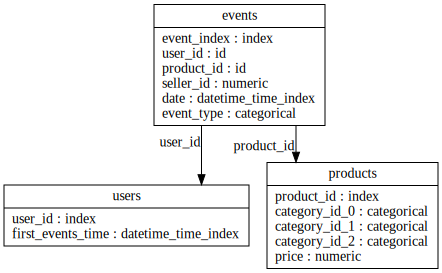

In [0]:
es.plot()

In [0]:
##feature_defs = ft.dfs(entityset=es, target_entity="users",
##                                      agg_primitives=['Count','num_unique','Min', 'Max', 'Mean','Sum', 'Std', 'Mode', 'time_since_last'],
##                                     trans_primitives=["time_since_previous"],
  ##                                    where_primitives=["count", "avg_time_between"],
    ##                                  training_window = ft.Timedelta(120, unit="d"),
      ##                                cutoff_time=pd.datetime(2014,8,1), 
        ##                              features_only=True)

In [0]:
es["events"]["event_type"].interesting_values = ["buy_order"]
expensive_purchase = ft.Feature(es["products"]["price"]) > 0.0
buy_order = ft.Feature(es["events"]["event_type"]) == 'buy_order'

In [0]:
feature_defs = ft.dfs(entityset=es, target_entity="users",
                                      agg_primitives=["count", "Sum", "mean","avg_time_between", 
                                                      "percent_true", "time_since_first", "time_since_last"],
                                      trans_primitives=['cum_sum'],
                                      where_primitives=["count"],
                                      seed_features=[buy_order, expensive_purchase],
                                      training_window = ft.Timedelta(120, unit="d"),
                                      cutoff_time=pd.datetime(2014,8,1), 
                                      features_only=True, max_depth=3, n_jobs = -1)

In [0]:
feature_defs

[<Feature: COUNT(events)>,
 <Feature: SUM(events.seller_id)>,
 <Feature: MEAN(events.seller_id)>,
 <Feature: AVG_TIME_BETWEEN(events.date)>,
 <Feature: TIME_SINCE_FIRST(events.date)>,
 <Feature: TIME_SINCE_LAST(events.date)>,
 <Feature: COUNT(events WHERE event_type = buy_order)>,
 <Feature: SUM(events.CUM_SUM(seller_id))>,
 <Feature: SUM(events.products.price)>,
 <Feature: MEAN(events.CUM_SUM(seller_id))>,
 <Feature: MEAN(events.products.price)>,
 <Feature: PERCENT_TRUE(events.event_type = buy_order)>,
 <Feature: CUM_SUM(COUNT(events))>,
 <Feature: CUM_SUM(SUM(events.seller_id))>,
 <Feature: CUM_SUM(MEAN(events.seller_id))>,
 <Feature: CUM_SUM(AVG_TIME_BETWEEN(events.date))>,
 <Feature: CUM_SUM(TIME_SINCE_FIRST(events.date))>,
 <Feature: CUM_SUM(TIME_SINCE_LAST(events.date))>,
 <Feature: SUM(events.products.COUNT(events))>,
 <Feature: SUM(events.products.SUM(events.seller_id))>,
 <Feature: SUM(events.products.MEAN(events.seller_id))>,
 <Feature: SUM(events.products.AVG_TIME_BETWEEN(ev

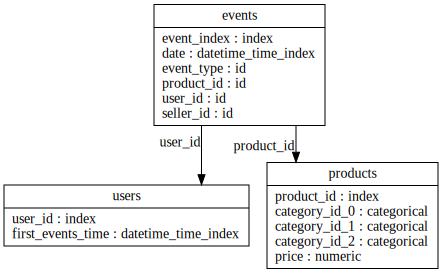

In [0]:
es.plot()

In [0]:
## todo : jointure avec tbl perim + target
feature_matrix_ = feature_matrix.reset_index(drop=False)
train_matrix = pd.merge(train, feature_matrix_, on='user_id', how='inner')
train_matrix.drop('_merge',axis=1).to_csv('train_matrix.csv')

In [0]:
## !pip install h20
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size='8g', nthreads=4)

ModuleNotFoundError: ignored

In [0]:
!pip install h2o

In [0]:
test = pd.read_csv('train_matrix.csv', index_col=['user_id'])
##test.info()

In [0]:
## check des trx
test[['total_spend_train', 'SUM(events.products.price)']][test['total_spend_train'] >= 30].head(5)

In [0]:
usr_143 = merged_df[merged_df.user_id==143]
print(config)
display(usr_143)
##todo : sortir event_type comme table nprmalisee pour calculer spend by event_type, ou le placer e, condition where

{'ref_date': datetime.date(2014, 8, 1), 'train_start_dt': datetime.date(2014, 4, 2), 'prediction_window': datetime.date(2014, 11, 30)}


,event_index,user_id,event_type,product_id,seller_id,date,category_id_0,category_id_1,category_id_2,price
56548,56548,143,buy_order,523332,53269,2014-09-06 13:00:00,1.0,112.0,61.0,25.02
56625,56625,143,seller_page,-999,62691,2014-09-06 13:00:00,NaN,NaN,NaN,NaN
1288665,1288665,143,seller_page,-999,69528,2015-03-08 09:00:00,NaN,NaN,NaN,NaN
1936659,1936659,143,product_page,225983,83300,2014-04-20 13:00:00,1.0,109.0,97.0,12.91
1938090,1938090,143,seller_page,-999,7225,2014-04-20 11:00:00,NaN,NaN,NaN,NaN
1939137,1939137,143,buy_order,246894,46141,2014-04-20 13:00:00,4.0,5.0,110.0,43.11
1940367,1940367,143,product_page,420659,83274,2014-04-20 13:00:00,1.0,39.0,38.0,17.05
1953643,1953643,143,product_page,621754,19251,2014-04-23 10:00:00,1.0,43.0,121.0,15.07
1958350,1958350,143,product_page,167019,22210,2014-04-23 10:00:00,7.0,107.0,104.0,80.27
1958682,1958682,143,product_page,670525,25140,2014-04-23 11:00:00,5.0,55.0,87.0,0.01


In [0]:
hdf = h2o.import_file('train_matrix.csv')
hdf = hdf.drop(['total_spend_pred','total_trx_pred', 'total_trx_train', 'total_spend_train'], axis=1)
## define target as binary class
hdf['target'] = hdf['target'].asfactor()
## define predictors
col_names = hdf.col_names
col_names.remove('user_id')
col_names.remove('C1')
col_names.remove('target')

hdf.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


C1,user_id,target,COUNT(events),NUM_UNIQUE(events.event_type),NUM_UNIQUE(events.product_id),NUM_UNIQUE(events.seller_id),MODE(events.event_type),MODE(events.product_id),MODE(events.seller_id),TIME_SINCE_LAST(events.date),NUM_UNIQUE(events.products.category_id_0),NUM_UNIQUE(events.products.category_id_1),NUM_UNIQUE(events.products.category_id_2),MIN(events.time_since_previous_by_product_id),MIN(events.time_since_previous_by_user_id),MIN(events.time_since_previous_by_seller_id),MIN(events.products.price),MAX(events.time_since_previous_by_product_id),MAX(events.time_since_previous_by_user_id),MAX(events.time_since_previous_by_seller_id),MAX(events.products.price),MEAN(events.time_since_previous_by_product_id),MEAN(events.time_since_previous_by_user_id),MEAN(events.time_since_previous_by_seller_id),MEAN(events.products.price),SUM(events.time_since_previous_by_product_id),SUM(events.time_since_previous_by_user_id),SUM(events.time_since_previous_by_seller_id),SUM(events.products.price),STD(events.time_since_previous_by_product_id),STD(events.time_since_previous_by_user_id),STD(events.time_since_previous_by_seller_id),STD(events.products.price),MODE(events.products.category_id_0),MODE(events.products.category_id_1),MODE(events.products.category_id_2)
0,1,churn,23,3,17,11,product_page,-999,43358,1.06704e+07,7,11,11,0,0,-7.6392e+06,5.5,5.7348e+06,3.5496e+06,7.1316e+06,135.37,940050,377018,163964,33.9369,7.5204e+06,8.2944e+06,3.6072e+06,542.99,1.96608e+06,787530,3.01938e+06,37.1451,1,39,38
1,143,active,10,3,9,10,product_page,-999,988,9.1044e+06,4,6,6,-7.362e+06,0,-5.7276e+06,0.01,68400,248400,1.2924e+06,80.27,-1.94616e+06,56000,-518760,30.45,-9.7308e+06,504000,-5.1876e+06,243.6,3.20793e+06,92784.9,1.94353e+06,26.57,1,39,38
2,164,active,280,3,217,86,product_page,-999,69436,1.73592e+07,10,58,58,-1.33056e+07,0,-1.38168e+07,0.01,9.6264e+06,1.5336e+06,1.19304e+07,1242.17,266328,53045.2,212413,34.6246,3.96828e+07,1.47996e+07,5.88384e+07,8032.9,2.90943e+06,174840,3.53529e+06,109.309,1,43,121
3,198,active,6,2,6,6,buy_order,1044,1183,3.2904e+06,3,6,6,nan,0,-828000,7.02,nan,172800,784800,120.06,nan,50400,-33600,37.685,0,252000,-201600,226.11,nan,76537,709445,42.9413,1,31,31
4,242,active,23,2,20,17,product_page,72105,19251,1.737e+07,7,14,14,-1.00512e+07,0,-1.23372e+07,2.51,1.06344e+07,4.3236e+06,1.38024e+07,369.9,1.00569e+06,701345,1.01144e+06,37.8433,1.40796e+07,1.54296e+07,2.32632e+07,794.71,5.26648e+06,1.26801e+06,5.81886e+06,77.0627,1,39,38
5,289,active,322,3,175,53,product_page,-999,27272,1.82628e+07,11,51,51,-1.8252e+07,0,-1.49508e+07,0.01,9.0828e+06,3.2796e+06,9.5472e+06,4.1093e+07,43854.5,56815,53697.2,195077,9.648e+06,1.82376e+07,1.72368e+07,4.21367e+07,2.42885e+06,221461,2.74943e+06,2.79659e+06,1,39,38
6,306,churn,6,2,6,6,product_page,94474,1559,8.4996e+06,5,6,6,97200,0,90000,12,1.1988e+06,691200,1.8684e+06,48.97,732000,293040,644400,28.8233,2.196e+06,1.4652e+06,2.5776e+06,172.94,569692,267814,840624,12.3845,1,7,38
7,349,churn,1,1,1,1,buy_order,420355,8397,8.3808e+06,1,1,1,212400,nan,-2.376e+06,30.03,212400,nan,-2.376e+06,30.03,212400,nan,-2.376e+06,30.03,212400,0,-2.376e+06,30.03,nan,nan,nan,nan,1,34,212
8,369,active,250,3,159,28,product_page,-999,4729,1.78848e+07,10,52,52,-1.6416e+07,0,-1.62432e+07,0.01,4.7592e+06,748800,1.06992e+07,554.97,-194247,71016.9,-182707,29.3561,-2.73888e+07,1.76832e+07,-4.56768e+07,5460.24,2.0835e+06,110908,2.48047e+06,67.9458,1,39,38
9,459,churn,4,2,4,4,product_page,119848,20394,5.0256e+06,3,3,3,nan,0,-1.5408e+06,0.01,nan,1.4436e+06,93600,1011.05,nan,549600,-600000,287.097,0,1.6488e+06,-1.8e+06,1148.39,nan,780995,844776,485.345,1,43,121


In [0]:
aml = H2OAutoML(max_models = 10, max_runtime_secs=300, seed = 1985, nfolds=10,
                stopping_rounds=20, include_algos=['DRF', 'GBM'])
aml.train(x = col_names, y = 'target', training_frame = hdf)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190522_130101_model_1,0.774468,0.482863,0.479688,0.396736,0.157399
DRF_1_AutoML_20190522_130101,0.76715,0.451057,0.47503,0.383486,0.147062
XRT_1_AutoML_20190522_130101,0.765192,0.452051,0.473353,0.383893,0.147374
GBM_4_AutoML_20190522_130101,0.760929,0.506622,0.482203,0.393187,0.154596
GBM_5_AutoML_20190522_130101,0.758886,0.471302,0.478707,0.388764,0.151137
GBM_3_AutoML_20190522_130101,0.75635,0.509461,0.484083,0.393758,0.155046
GBM_2_AutoML_20190522_130101,0.755657,0.511009,0.481692,0.393919,0.155172
GBM_1_AutoML_20190522_130101,0.755264,0.501814,0.480996,0.392895,0.154367


In [0]:
best_mdl = aml.leader
best_mdl.auc


Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_20190522_130101_model_1


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1503347532899899
RMSE: 0.3877302584142614
LogLoss: 0.46365227817712773
Mean Per-Class Error: 0.2072669172932331
AUC: 0.8357718850698174
pr_auc: 0.9492432947246796
Gini: 0.6715437701396347
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6854811686639226: 


,active,churn,Error,Rate
active,148.0,916.0,0.8609,(916.0/1064.0)
churn,34.0,3466.0,0.0097,(34.0/3500.0)
Total,182.0,4382.0,0.2082,(950.0/4564.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6854812,0.8794722,305.0
max f2,0.5976031,0.9444775,356.0
max f0point5,0.7676380,0.8862161,213.0
max accuracy,0.6854812,0.7918493,305.0
max precision,0.8616735,1.0,0.0
max recall,0.5535763,1.0,374.0
max specificity,0.8616735,1.0,0.0
max absolute_mcc,0.7809821,0.4956328,194.0
max min_per_class_accuracy,0.6887861,0.7405714,302.0
max mean_per_class_accuracy,0.7809821,0.7927331,194.0


Gains/Lift Table: Avg response rate: 76.69 %, avg score: 76.66 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100789,0.8606274,1.304,1.304,1.0,0.8611870,1.0,0.8611870,0.0131429,0.0131429,30.4000000,30.4000000
,2,0.0201578,0.8597981,1.304,1.304,1.0,0.8602066,1.0,0.8606968,0.0131429,0.0262857,30.4000000,30.4000000
,3,0.0300175,0.8590749,1.304,1.304,1.0,0.8594263,1.0,0.8602795,0.0128571,0.0391429,30.4000000,30.4000000
,4,0.0400964,0.8583588,1.304,1.304,1.0,0.8587065,1.0,0.8598841,0.0131429,0.0522857,30.4000000,30.4000000
,5,0.0501753,0.8575980,1.304,1.304,1.0,0.8579902,1.0,0.8595036,0.0131429,0.0654286,30.4000000,30.4000000
,6,0.1001315,0.8544160,1.304,1.304,1.0,0.8560445,1.0,0.8577779,0.0651429,0.1305714,30.4000000,30.4000000
,7,0.1500876,0.8502591,1.304,1.304,1.0,0.8524193,1.0,0.8559943,0.0651429,0.1957143,30.4000000,30.4000000
,8,0.2000438,0.8445756,1.2982807,1.3025717,0.9956140,0.8474397,0.9989047,0.8538580,0.0648571,0.2605714,29.8280702,30.2571742
,9,0.2999562,0.8351733,1.2925614,1.2992374,0.9912281,0.8396724,0.9963477,0.8491329,0.1291429,0.3897143,29.2561404,29.9237400
,10,0.4000876,0.8188184,1.2783195,1.2940022,0.9803063,0.8281385,0.9923330,0.8438785,0.128,0.5177143,27.8319475,29.4002191




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.15739925782190173
RMSE: 0.39673575314294746
LogLoss: 0.48286304662349744
Mean Per-Class Error: 0.26228195488721806
AUC: 0.7744676423200859
pr_auc: 0.9167964786291396
Gini: 0.5489352846401718
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6203208699125409: 


,active,churn,Error,Rate
active,49.0,1015.0,0.9539,(1015.0/1064.0)
churn,19.0,3481.0,0.0054,(19.0/3500.0)
Total,68.0,4496.0,0.2266,(1034.0/4564.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6203209,0.8706853,355.0
max f2,0.4369083,0.9428371,396.0
max f0point5,0.7424468,0.8578226,262.0
max accuracy,0.6412685,0.7738826,342.0
max precision,0.8992703,1.0,0.0
max recall,0.4369083,1.0,396.0
max specificity,0.8992703,1.0,0.0
max absolute_mcc,0.7559405,0.4063221,246.0
max min_per_class_accuracy,0.7062403,0.722,294.0
max mean_per_class_accuracy,0.7559405,0.7377180,246.0


Gains/Lift Table: Avg response rate: 76.69 %, avg score: 76.73 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100789,0.8929582,1.2756522,1.2756522,0.9782609,0.8955569,0.9782609,0.8955569,0.0128571,0.0128571,27.5652174,27.5652174
,2,0.0201578,0.8881638,1.304,1.2898261,1.0,0.8903182,0.9891304,0.8929375,0.0131429,0.026,30.4000000,28.9826087
,3,0.0300175,0.8830163,1.2750222,1.2849635,0.9777778,0.8856390,0.9854015,0.8905402,0.0125714,0.0385714,27.5022222,28.4963504
,4,0.0400964,0.8769863,1.2756522,1.2826230,0.9782609,0.8798346,0.9836066,0.8878492,0.0128571,0.0514286,27.5652174,28.2622951
,5,0.0501753,0.8704635,1.1906087,1.2641397,0.9130435,0.8741007,0.9694323,0.8850875,0.012,0.0634286,19.0608696,26.4139738
,6,0.1001315,0.8492090,1.2696842,1.2669059,0.9736842,0.8556129,0.9715536,0.8703824,0.0634286,0.1268571,26.9684211,26.6905908
,7,0.1500876,0.8444992,1.2639649,1.2659270,0.9692982,0.8466023,0.9708029,0.8624673,0.0631429,0.19,26.3964912,26.5927007
,8,0.2000438,0.8399228,1.2525263,1.2625805,0.9605263,0.8423153,0.9682366,0.8574348,0.0625714,0.2525714,25.2526316,26.2580504
,9,0.2999562,0.8291189,1.2039123,1.2430387,0.9232456,0.8345648,0.9532505,0.8498171,0.1202857,0.3728571,20.3912281,24.3038714
,10,0.4000876,0.8154016,1.2069847,1.2340153,0.9256018,0.8229413,0.9463308,0.8430907,0.1208571,0.4937143,20.6984683,23.4015334



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
accuracy,0.779135,0.0103730,0.7724289,0.7746171,0.7768052,0.8205689,0.7785088,0.7719298,0.7807018,0.7631579,0.7807018,0.7719298
auc,0.7757018,0.0189872,0.7397171,0.7806030,0.7912672,0.8297147,0.7734183,0.7488706,0.7496988,0.7850279,0.8040162,0.7546848
err,0.2208650,0.0103730,0.2275711,0.2253829,0.2231947,0.1794311,0.2214912,0.2280702,0.2192982,0.2368421,0.2192982,0.2280702
err_count,100.8,4.7095647,104.0,103.0,102.0,82.0,101.0,104.0,100.0,108.0,100.0,104.0
f0point5,0.8136758,0.0091097,0.8086507,0.8107488,0.8136300,0.8498117,0.8111267,0.8070588,0.8142255,0.7980226,0.8146592,0.8088235
f1,0.8736765,0.0062335,0.8686869,0.8726823,0.8731343,0.8980100,0.872956,0.8683544,0.8743719,0.8625954,0.8746867,0.8712871
f2,0.9433083,0.0026926,0.9383524,0.9448608,0.942029,0.9520042,0.9449891,0.9397260,0.9441128,0.9385382,0.9442641,0.944206
lift_top_group,1.3043671,0.0151275,1.3170029,1.2946175,1.2946175,1.2554945,1.314121,1.3217391,1.3065902,1.3411765,1.3028572,1.2954545
logloss,0.4828689,0.0159022,0.5045474,0.4806098,0.4765513,0.4428926,0.4929955,0.5057812,0.4966481,0.5109757,0.4492861,0.4684016
max_per_class_error,0.9346701,0.0284422,0.9181818,0.9903846,0.9615384,0.8494624,0.9266055,0.9189189,0.9252337,0.9224138,0.9339623,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-05-22 13:05:57,13.941 sec,0.0,0.4228236,0.5430294,0.5,0.0,1.0,0.2331288
,2019-05-22 13:05:57,14.035 sec,5.0,0.4182163,0.5322456,0.8183406,0.9110523,1.304,0.2145048
,2019-05-22 13:05:57,14.130 sec,10.0,0.4139535,0.5224340,0.8232899,0.9409865,1.304,0.2160386
,2019-05-22 13:05:57,14.226 sec,15.0,0.4100000,0.5134419,0.8271269,0.9427266,1.304,0.2118755
,2019-05-22 13:05:57,14.323 sec,20.0,0.4062982,0.5051122,0.8295681,0.9450273,1.304,0.2109991
,2019-05-22 13:05:57,14.420 sec,25.0,0.4028647,0.4974275,0.8281030,0.9452830,1.304,0.2109991
,2019-05-22 13:05:58,14.526 sec,30.0,0.3996449,0.4902865,0.8288895,0.9481562,1.304,0.2118755
,2019-05-22 13:05:58,14.620 sec,35.0,0.3967606,0.4838653,0.8312244,0.9477039,1.304,0.2101227
,2019-05-22 13:05:58,14.719 sec,40.0,0.3940053,0.4777265,0.8317675,0.9484900,1.304,0.2096845
,2019-05-22 13:05:58,14.822 sec,45.0,0.3914778,0.4720622,0.8333711,0.9492964,1.304,0.2090272


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NUM_UNIQUE(events.products.category_id_0),1026.7587891,1.0,0.1691453
NUM_UNIQUE(events.product_id),1018.4805298,0.9919375,0.1677816
NUM_UNIQUE(events.products.category_id_2),751.9967651,0.7323987,0.1238818
NUM_UNIQUE(events.products.category_id_1),619.0935059,0.6029591,0.1019877
NUM_UNIQUE(events.seller_id),414.4820862,0.4036801,0.0682806
---,---,---,---
SUM(events.products.price),11.3651886,0.0110690,0.0018723
STD(events.products.price),10.9614401,0.0106758,0.0018058
MIN(events.time_since_previous_by_user_id),7.9813113,0.0077733,0.0013148
MAX(events.products.price),5.3003263,0.0051622,0.0008732



See the whole table with table.as_data_frame()


<bound method ModelBase.auc of >

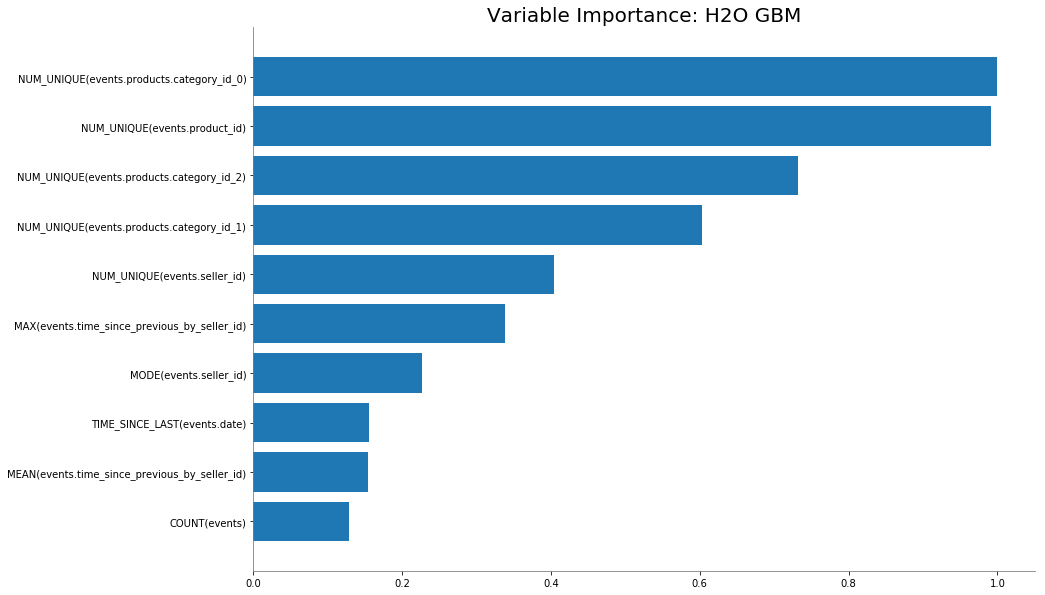

In [0]:
best_mdl.varimp_plot()

In [0]:
## try with mljar 
!pip install mljar-supervised

In [0]:
from supervised.automl import AutoML

X = df[df.columns[:-1]]
y = df["income"]

automl = AutoML()
automl.fit(X, y)

predictions = automl.predict(X)